In [1]:
import os.path
import os
import sys
import nn2graph
import mnist
import dnn
from tensorflow.keras.models import load_model
import graph_tool as gt
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
plt.rcParams.update({'font.size': 22})
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.insert(0, "/Users/mchifala/Desktop/CSCI_5352_Network_Analysis/dnn-community-detection")

from dnn import load_run
from nn2graph import dense_activations_to_graph
from statistics import mean
import itertools as it
from joblib import Parallel, delayed

#### Get the images of 1's with hats vs. no hats

In [14]:
import os
hats = os.listdir(os.path.join(os.getcwd(),"ones_hats_train"))
hats = [int(x.split(".")[0]) for x in hats]

no_hats = os.listdir(os.path.join(os.getcwd(),"ones_no_hats_train"))
no_hats = [int(x.split(".")[0]) for x in no_hats]
ones_inds = np.concatenate((hats, no_hats))

[30556 38526 31264 45532  9492 38724 33856  8772 50857 18768  5691  4014
 56836 49902 20746 22192 18226 37038 52878 47291  9693 50855 14756 31930
 41554 16418 15878  7898 17262   982 23886 32814 12508 55870  5876 26444
 53746 53168 42702 33110 39818 49482    70 20018 59297 28650 41816 50847
  7860 15300 53194 16392  3811 34640 56576 52738 41744 35774 13604  2448
 40944  4710 50799 23788 20322 44698 46058 18656 38974 15164  8704  3644
 35538 31366 30508 30244 49787  2410 37926 50771 53330  8934  4129 58072
 45962 25310 50572 31198  9550 21402 29062 11502 47234 22490 54506 50827
 21990 24624 47340 33600 57378 45032 23604 34542 38436 19188 48306 36814
 30068  6328  3456 42986 24424 17213 10420  4502 11702 50789  4066 32440
 26376 19804  2426 25910  7402 41266 10982 20672 50632 50829 24038 47004
 33752 52392 53098  5174 48916 37330 12166 19782 50396 50751 49002 11292
 22328 41894 44046 34402  7160 38774  8904 36956 19036 29320 50797 33224
 14314 40976 32338 33024 32306 19168 32892    24 32

#### Convert neural network to graph

In [17]:
N = 5000
num_runs = 3
rand_inds = mnist.subsample_train(N)
def get_activation_networks(inputs, run=1, num_layers=4, num_epochs=10):
    from tensorflow.keras.layers import Dense
    model = dnn.load_run(run+1, num_layers=num_layers, num_epochs=num_epochs)
    layer_sizes = [mnist.X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
    _, g_xs = nn2graph.dense_activations_to_graph(model, inputs)
    return g_xs, layer_sizes

def get_layer_sizes(inputs, num_layers=4, num_outputs=10, hidden_dims=64):
    layer_sizes = [inputs[0].shape[-1]]
    for i in range(num_layers):
        layer_sizes.append(hidden_dims)
    layer_sizes.append(num_outputs)
    return layer_sizes

#### Mean weighted degree distribution for ones. Note: I changed from X_test to X_train

In [24]:
def compute_mean_weighted_degrees(inputs):
    mean_weighted_degrees = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(mnist.X_train[ones_inds], run=i)
        mean_weighted_degrees.append([float(g.vp['degree'].a[inputs.shape[-1]:].mean()) for g in g_xs])
        del g_xs
    mean_weighted_degrees = np.array(mean_weighted_degrees).mean(axis=0)
    return mean_weighted_degrees
    
def compute_mean_weighted_degrees_by_layer(inputs):
    mean_weighted_degrees_by_layer = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(mnist.X_train[ones_inds], run=i)
        layer_mean_degrees = []
        for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
            mean_weighted_degrees = [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]
            layer_mean_degrees.append(mean_weighted_degrees)
        mean_weighted_degrees_by_layer.append(np.array(layer_mean_degrees))
        del g_xs
    mean_weighted_degrees_by_layer = np.array(mean_weighted_degrees_by_layer).mean(axis=0)
    return mean_weighted_degrees_by_layer

mean_weighted_degrees = compute_mean_weighted_degrees(mnist.X_train[ones_inds])
mean_weighted_degrees_by_layer = compute_mean_weighted_degrees_by_layer(mnist.X_train[ones_inds])

#### Mean weighted degrees vs number of active inputs of 1's plot

,index,active inputs,digit class,mean weighted degree,hat
0,30556,105.0,1,107.960517,hat
1,38526,117.0,1,101.519125,hat
2,31264,114.0,1,105.593324,hat
3,45532,126.0,1,127.295088,hat
4,9492,80.0,1,97.661954,hat
...,...,...,...,...,...
465,2086,71.0,1,97.140129,no hat
466,184,70.0,1,90.382830,no hat
467,609,110.0,1,121.810425,no hat
468,345,96.0,1,118.035827,no hat


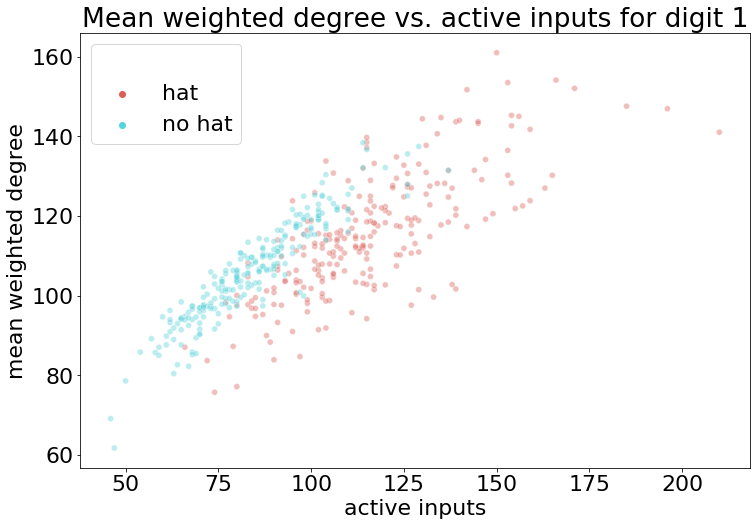

In [43]:
g_xs_degree_ones = pd.DataFrame({'active inputs': np.sum(mnist.X_train[ones_inds], axis=1),
                                      'digit class': mnist.train_labels[ones_inds],
                                      'mean weighted degree': mean_weighted_degrees},
                                       index = ones_inds)

g_xs_degree_ones.reset_index(inplace = True)
g_xs_degree_ones["hat"] = g_xs_degree_ones["index"].apply(lambda x: "hat" if x in hats else "no hat")

display(g_xs_degree_ones)
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='hat',
                palette=sns.color_palette('hls', 2), alpha=0.4,
                data=g_xs_degree_ones)
ax.legend().texts[0].set_text("")
ax.set_title('Mean weighted degree vs. active inputs for digit 1')
plt.show()

#### Mean weighted degrees vs number of active inputs of 1's by layer

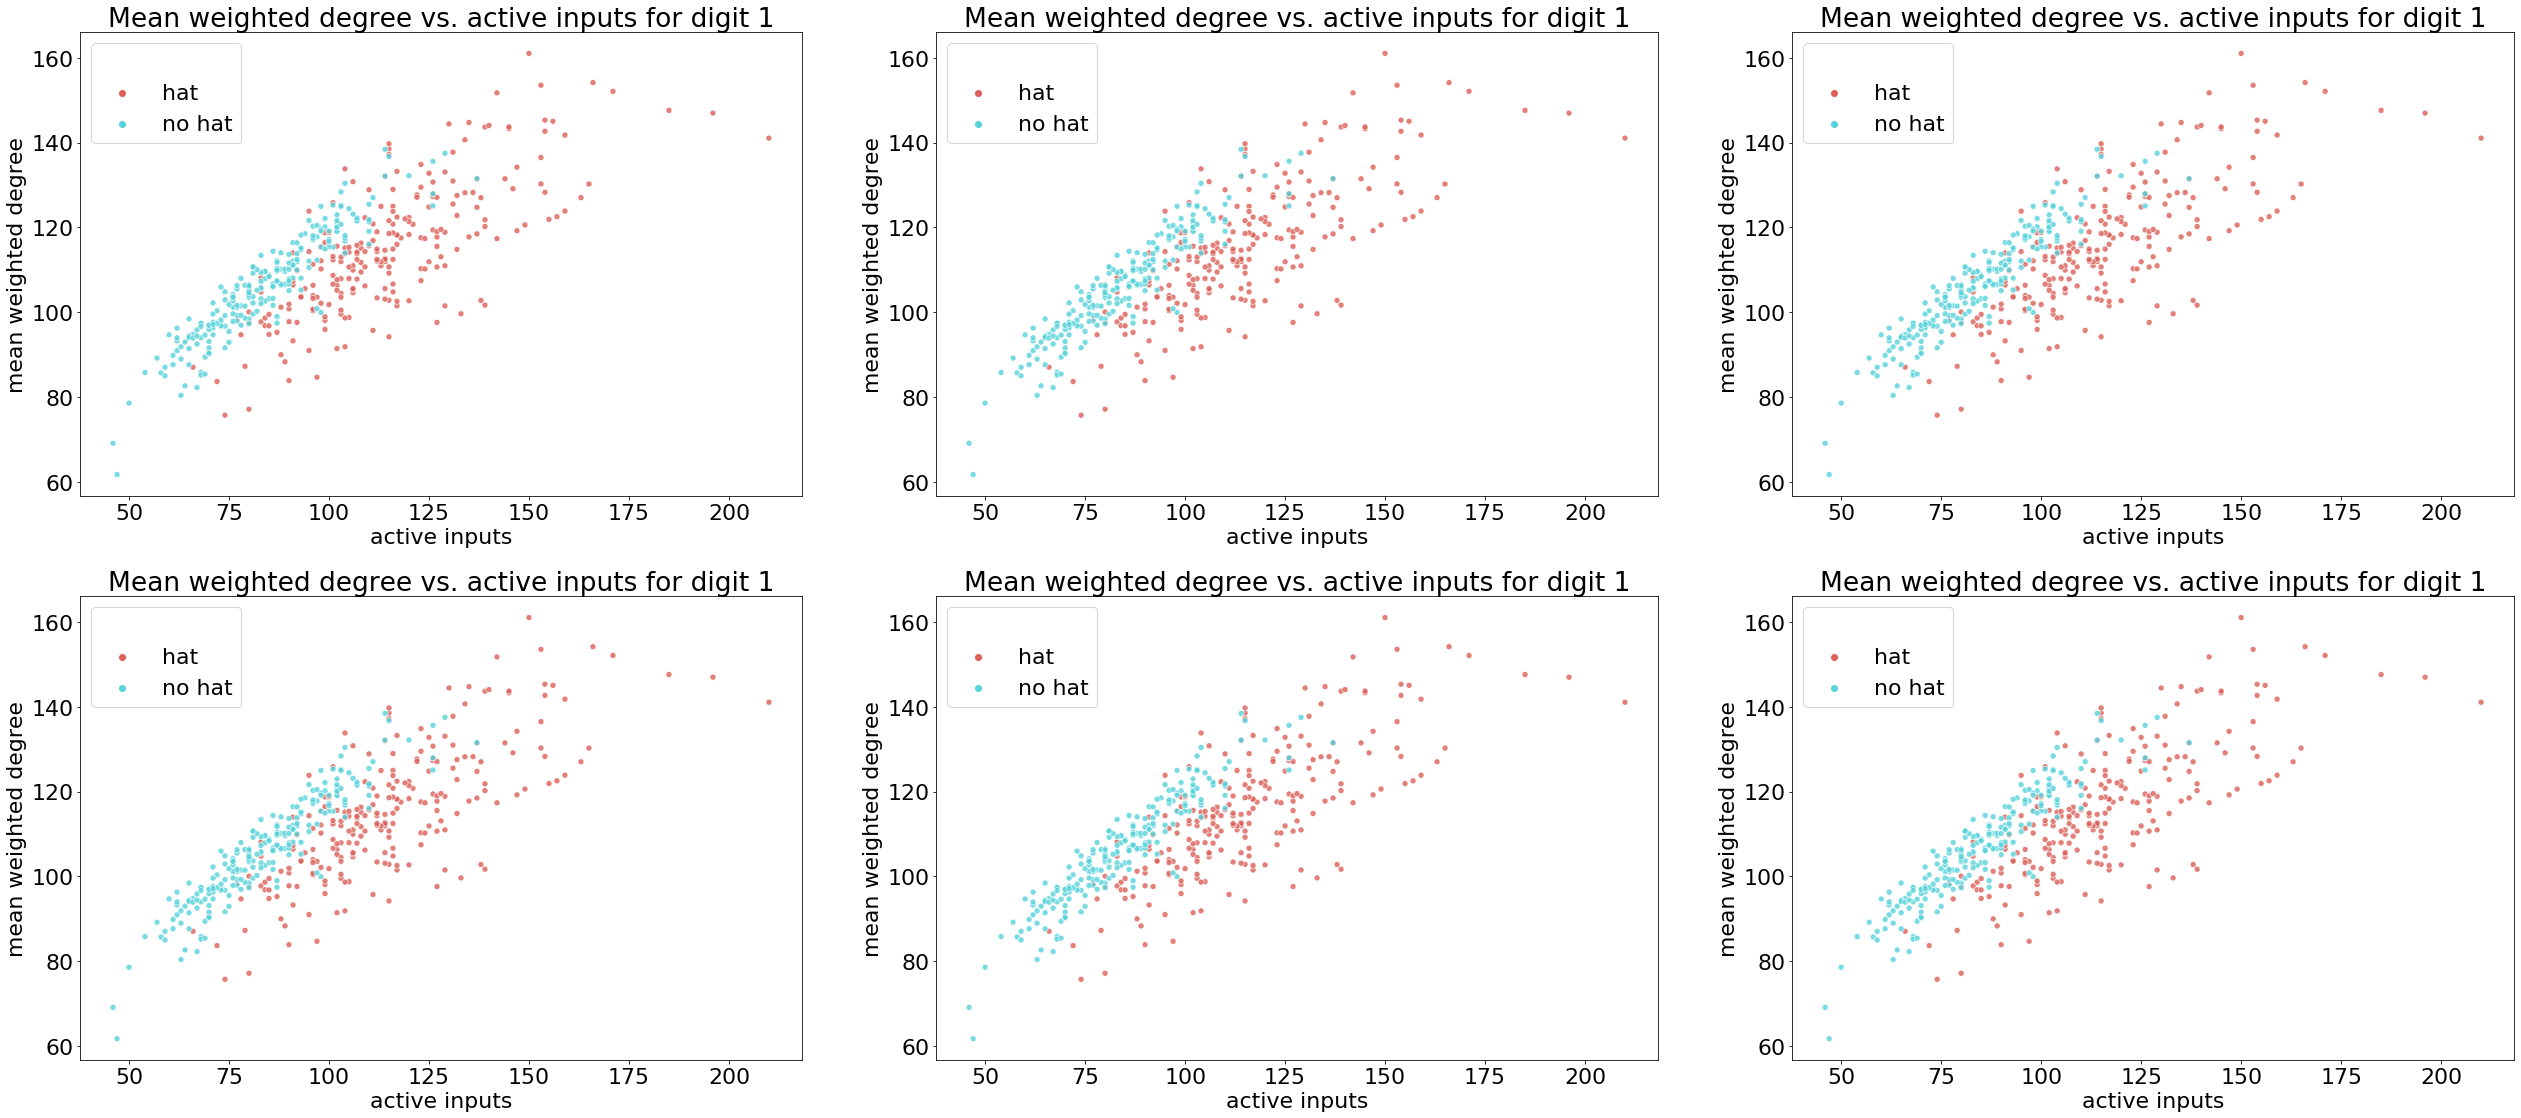

In [48]:
layer_sizes = [784, 64, 64, 64, 64, 10]
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_degree_ones_layers = pd.DataFrame({'active inputs': np.sum(mnist.X_train[ones_inds], axis=1),
                                          'digit class': mnist.train_labels[ones_inds],
                                          'mean weighted degree': mean_weighted_degrees},
                                          index = ones_inds)

    g_xs_degree_ones_layers.reset_index(inplace = True)
    g_xs_degree_ones_layers["hat"] = g_xs_degree_ones_layers["index"].apply(lambda x: "hat" if x in hats else "no hat")
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='hat',
                    palette=sns.color_palette('hls', 2), alpha=0.8,
                    data=g_xs_degree_ones_layers,
                    ax=ax)
    ax.legend().texts[0].set_text("")
    ax.set_title('Mean weighted degree vs. active inputs for digit 1')
plt.tight_layout()
plt.show()

#### Investigate changes over time to mnist model

In [92]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tensorflow.keras.layers import Dense
from dnn import load_run
from nn2graph import dense_activations_to_graph
import mnist
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from statistics import mean
import itertools as it
from joblib import Parallel, delayed

N = 500
rand_inds = mnist.subsample_test(N)

def get_mean_degs(run, hidden_layers, layer, epoch):
    model = load_run(run=str(run), num_layers=str(hidden_layers), num_epochs=epoch)
    g_full, g_xs = dense_activations_to_graph(model, mnist.X_test[rand_inds])
    degs = [float(g.vp['degree'].a[g.vp["layer"].a==layer].mean()) for g in g_xs]
    
    del g_full
    del g_xs
    
    return degs
                
def run_epochs(hidden_layers, layer):
    return [np.mean([get_mean_degs(run, hidden_layers, layer, epoch) for run in range(1,4)]) for epoch in range(1,11)]

params = [(hidden_layers, layer) for hidden_layers, layer in \
          it.product(range(1,5), range(1,5)) if layer <= hidden_layers]
parallel = Parallel(n_jobs=10, verbose=10)
results = parallel(delayed(run_epochs)(hidden_layers, layer) for hidden_layers, layer in params)
plot_dict = {hidden_layer: {layer: res for ((_, layer), res) in group} for hidden_layer, group in it.groupby(zip(params, results), lambda pr: pr[0][0])}

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  4.1min remaining:  9.5min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  4.3min remaining:  4.3min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  4.4min remaining:  1.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  4.4min finished


1
2
3
4


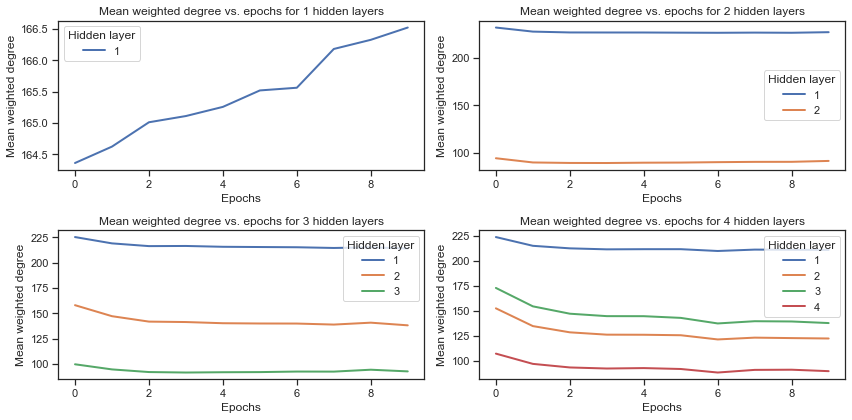

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(12,6))
sns.set(style="ticks", rc={"lines.linewidth": 2})
plt.rcParams.update({'font.size': 12})
for i in range(1, len(plot_dict)+1):
    print(i)
    ax = axs[0 if i <= 2 else 1, (i-1)%2]
    df = pd.DataFrame(plot_dict[i])
    sns.lineplot(data = df, ax=ax, dashes = False)
    ax.set_title("Mean weighted degree vs. epochs for "+str(i)+" hidden layers")
    ax.set(xlabel='Epochs', ylabel='Mean weighted degree')
    ax.legend(title="Hidden layer")
plt.tight_layout()